In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.cross_validation import train_test_split
from models.cascade_base import CascadeBase
from utils.visualizer import Visualizer
from IPython.display import SVG, display

import numpy as np
import matplotlib.pyplot as plt

import time
import pydot
import lasagne

plt.style.use('ggplot')

%matplotlib notebook

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)
/home/apanin/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
def get_hex_color(layer_type):
    """
    Determines the hex color for a layer.
    :parameters:
        - layer_type : string
            Class name of the layer
    :returns:
        - color : string containing a hex color for filling block.
    """
    COLORS = ['#4A88B3', '#98C1DE', '#6CA2C8', '#3173A2', '#17649B',
              '#FFBB60', '#FFDAA9', '#FFC981', '#FCAC41', '#F29416',
              '#C54AAA', '#E698D4', '#D56CBE', '#B72F99', '#B0108D',
              '#75DF54', '#B3F1A0', '#91E875', '#5DD637', '#3FCD12']

    hashed = int(hash(layer_type)) % 5

    if "conv" in layer_type.lower():
        return COLORS[:5][hashed]
    if layer_type in lasagne.layers.pool.__all__:
        return COLORS[5:10][hashed]
    if layer_type in lasagne.layers.recurrent.__all__:
        return COLORS[10:15][hashed]
    else:
        return COLORS[15:20][hashed]

def make_pydot_graph(layers, output_shape=True, verbose=False):
    """
    :parameters:
        - layers : list
            List of the layers, as obtained from lasagne.layers.get_all_layers
        - output_shape: (default `True`)
            If `True`, the output shape of each layer will be displayed.
        - verbose: (default `False`)
            If `True`, layer attributes like filter shape, stride, etc.
            will be displayed.
    :returns:
        - pydot_graph : PyDot object containing the graph
    """

    pydot_graph = pydot.Dot('Network', graph_type='digraph')
    pydot_nodes = {}
    pydot_edges = []
    for i, layer in enumerate(layers):
        layer_type = '{0}'.format(layer.__class__.__name__)
        layer_name = layer.name if layer.name is not None else ''
        key = repr(layer)
        label = layer_name + ' ' + layer_type
        color = get_hex_color(layer_type)
        if verbose:
            for attr in ['num_filters', 'num_units', 'ds',
                         'filter_shape', 'stride', 'strides', 'p']:
                if hasattr(layer, attr):
                    label += '\n{0}: {1}'.format(attr, getattr(layer, attr))
            if hasattr(layer, 'nonlinearity'):
                try:
                    nonlinearity = layer.nonlinearity.__name__
                except AttributeError:
                    nonlinearity = layer.nonlinearity.__class__.__name__
                label += '\nnonlinearity: {0}'.format(nonlinearity)

        if output_shape:
            label += '\nOutput shape: {0}'.format(layer.output_shape)

        pydot_nodes[key] = pydot.Node(
            key, label=label, shape='record', fillcolor=color, style='filled')

        if hasattr(layer, 'input_layers'):
            for input_layer in layer.input_layers:
                pydot_edges.append([repr(input_layer), key])

        if hasattr(layer, 'input_layer'):
            pydot_edges.append([repr(layer.input_layer), key])

    for node in pydot_nodes.values():
        pydot_graph.add_node(node)

    for edges in pydot_edges:
        pydot_graph.add_edge(
            pydot.Edge(pydot_nodes[edges[0]], pydot_nodes[edges[1]]))
    return pydot_graph

def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt], targets[excerpt]


def learn(nn,
          dataset,
          watches=['obj',
                   'recall',
                   'precision',
                   'accuracy',
                   'loss',
                   'sub_loss'],
          num_epochs=100,
          batch_size=50):
    '''
        num_epochs - amount of passes through the data
        batch_size - number of samples processed at each function call
        dataset - [X_train, X_val, y_train, y_val]
    '''
    %matplotlib notebook
    
    X_train, X_val, y_train, y_val = dataset
    metrics_template = dict()
    
    metrics_sample = nn.evaluate(X_val[:2], y_val[:2])
    
    for metric_name, _ in metrics_sample.items():
        if metric_name == 'complexity_parts':
            metrics_template[metric_name] = [0] * len(metrics_sample[metric_name])
        else:
            metrics_template[metric_name] = 0
        
    visualizer = Visualizer(num_epochs,
                            metrics_template,
                            watches=watches)
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        
        train_measurements = dict(metrics_template)
        train_batches = 0

        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.train(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        train_measurements[metric_name][j] += metric[j]
                else: 
                    train_measurements[metric_name] += metric

            train_batches += 1
            
        for metric_name, metric in train_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    train_measurements[metric_name][j] = metric[j] / train_batches
            else: 
                train_measurements[metric_name] = metric / train_batches

        # And a full pass over the validation data:
        val_measurements = dict(metrics_template)
        val_batches = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.evaluate(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        val_measurements[metric_name][j] += metric[j]
                else: 
                    val_measurements[metric_name] += metric

            val_batches += 1
            
        for metric_name, metric in val_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    val_measurements[metric_name][j] = metric[j] / val_batches
            else: 
                val_measurements[metric_name] = metric / val_batches

        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        visualizer.watch(train_measurements, val_measurements)
    visualizer.finish()
    
def draw(network):
    with open('../images/net.svg', 'w') as f:
        g = make_pydot_graph(lasagne.layers.get_all_layers(network))
        f.write(g.create_svg(f='svg'))

    display(SVG(filename='../images/net.svg'))

In [5]:
dataset = np.load('../data/not_bright/imgs_0001.npy')
targets = np.load('../data/not_bright/masks_0001.npy')

track_targets = targets.copy()
track_targets[track_targets <=0] = 0

In [13]:
X_y = train_test_split(dataset.reshape(-1, 1, 512, 512).astype(np.float32),
                       track_targets.reshape(-1, 1, 512, 512).astype(np.float32))

## Retrain the network

In [18]:
network = CascadeBase(img_shape=(512, 512),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=5e-1,
                      c_sub_objs=[5e-1, 1, 1],
                      c_sub_obj_cs=[1e-2, 1e-1, 1e-1],
                      mul=True,
                      pool_sizes=[2, 2, 2, 2],
                      num_filters=[1, 1, 3, 6],
                      filter_sizes=[1, 3, 3, 3],
                      l2_c=1e-4)

In [19]:
network.load('../weights', '3cascades_trained')

<IPython.core.display.Javascript object>


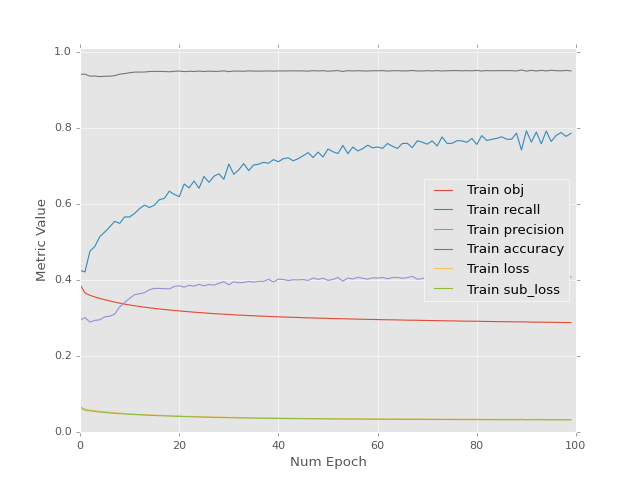

<IPython.core.display.Javascript object>


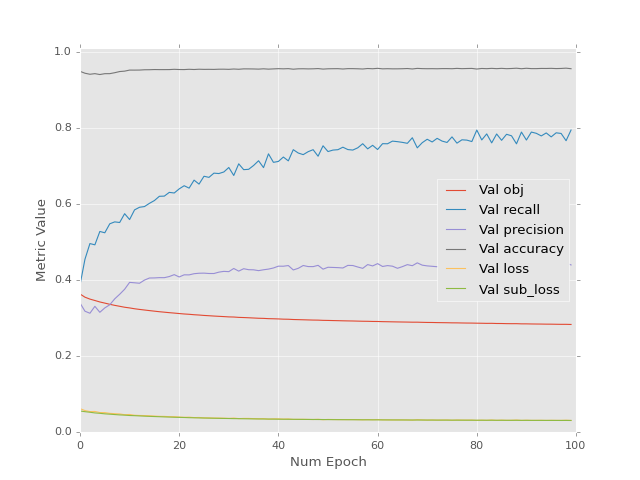

<IPython.core.display.Javascript object>


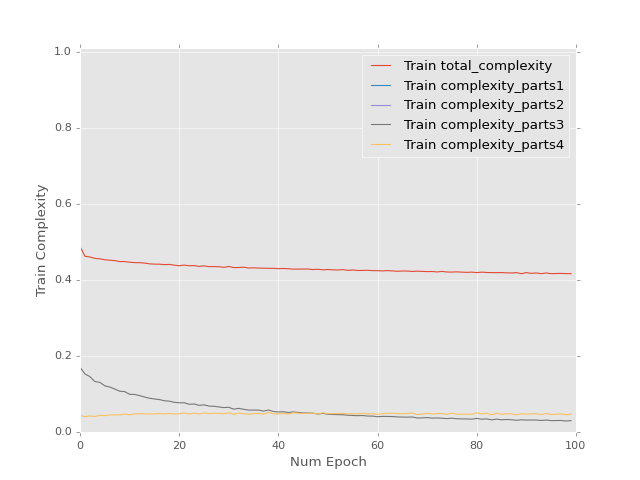

<IPython.core.display.Javascript object>


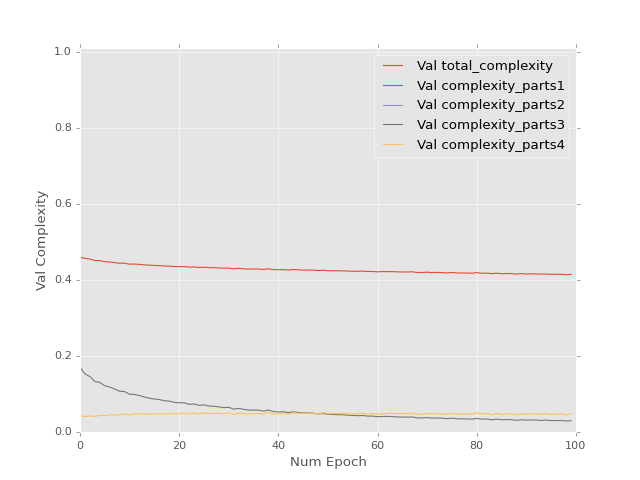

Epoch 1 of 100 took 15.407s
Epoch 2 of 100 took 15.140s
Epoch 3 of 100 took 15.258s
Epoch 4 of 100 took 15.223s
Epoch 5 of 100 took 14.867s
Epoch 6 of 100 took 15.184s
Epoch 7 of 100 took 15.232s
Epoch 8 of 100 took 14.951s
Epoch 9 of 100 took 15.451s
Epoch 10 of 100 took 14.706s
Epoch 11 of 100 took 14.745s
Epoch 12 of 100 took 14.777s
Epoch 13 of 100 took 14.664s
Epoch 14 of 100 took 14.605s
Epoch 15 of 100 took 15.012s
Epoch 16 of 100 took 14.858s
Epoch 17 of 100 took 14.738s
Epoch 18 of 100 took 14.770s
Epoch 19 of 100 took 14.621s
Epoch 20 of 100 took 14.561s
Epoch 21 of 100 took 14.755s
Epoch 22 of 100 took 14.668s
Epoch 23 of 100 took 14.537s
Epoch 24 of 100 took 14.736s
Epoch 25 of 100 took 14.676s
Epoch 26 of 100 took 14.526s
Epoch 27 of 100 took 14.769s
Epoch 28 of 100 took 14.842s
Epoch 29 of 100 took 14.524s
Epoch 30 of 100 took 14.635s
Epoch 31 of 100 took 14.581s
Epoch 32 of 100 took 14.666s
Epoch 33 of 100 took 14.662s
Epoch 34 of 100 took 14.633s
Epoch 35 of 100 took 14

In [20]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)

In [21]:
network.save('../weights', '3cascade_hard_dataset')

## Adjust Coefficients

In [ ]:
network = CascadeBase(img_shape=(512, 512),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=1,
                      c_sub_objs=[1, 1, 1],
                      c_sub_obj_cs=[1e-2, 1e-1, 1e-1],
                      mul=True,
                      pool_sizes=[2, 2, 2, 2],
                      num_filters=[1, 1, 3, 6],
                      filter_sizes=[1, 3, 3, 3],
                      l2_c=1e-3)

In [23]:
network.load('../weights', '3cascade_hard_dataset')

<IPython.core.display.Javascript object>


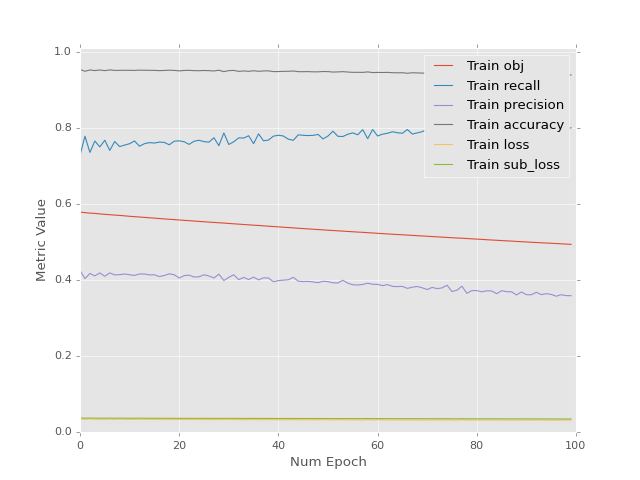

<IPython.core.display.Javascript object>


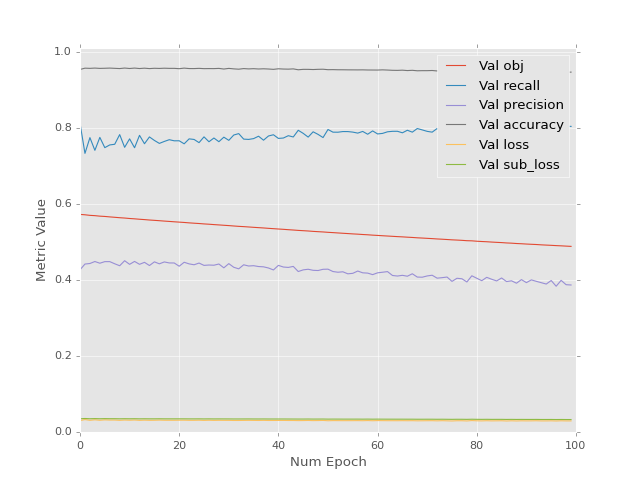

<IPython.core.display.Javascript object>


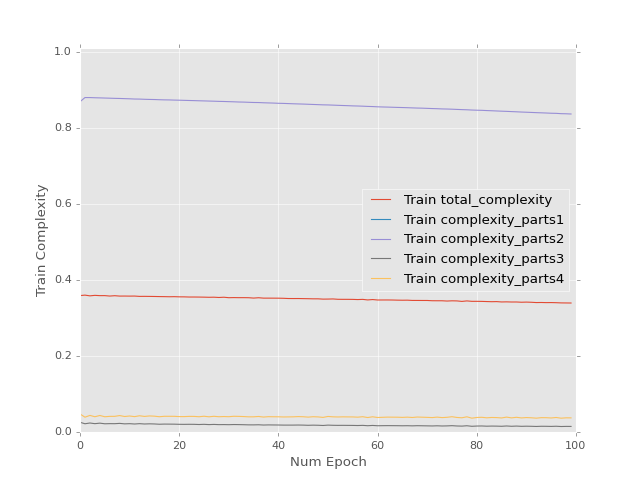

<IPython.core.display.Javascript object>


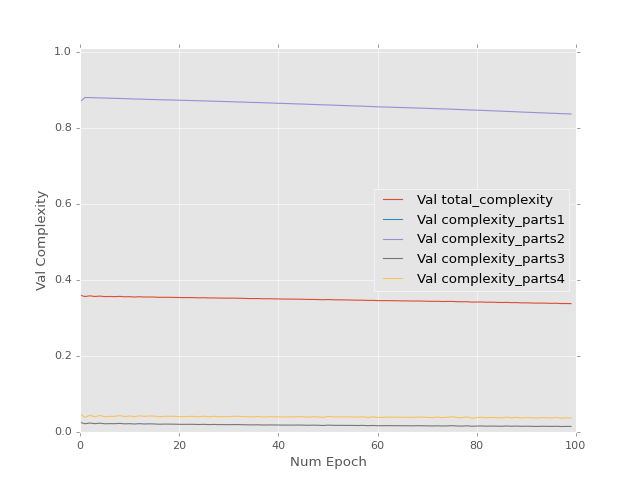

Epoch 1 of 100 took 15.488s
Epoch 2 of 100 took 15.365s
Epoch 3 of 100 took 14.857s
Epoch 4 of 100 took 14.667s
Epoch 5 of 100 took 14.724s
Epoch 6 of 100 took 14.935s
Epoch 7 of 100 took 15.212s
Epoch 8 of 100 took 14.836s
Epoch 9 of 100 took 14.847s
Epoch 10 of 100 took 14.786s
Epoch 11 of 100 took 14.956s
Epoch 12 of 100 took 14.975s
Epoch 13 of 100 took 14.856s
Epoch 14 of 100 took 14.830s
Epoch 15 of 100 took 14.818s
Epoch 16 of 100 took 14.812s
Epoch 17 of 100 took 14.702s
Epoch 18 of 100 took 14.898s
Epoch 19 of 100 took 14.811s
Epoch 20 of 100 took 14.749s
Epoch 21 of 100 took 14.829s
Epoch 22 of 100 took 14.835s
Epoch 23 of 100 took 14.713s
Epoch 24 of 100 took 14.768s
Epoch 25 of 100 took 14.942s
Epoch 26 of 100 took 14.753s
Epoch 27 of 100 took 14.735s
Epoch 28 of 100 took 14.873s
Epoch 29 of 100 took 14.808s
Epoch 30 of 100 took 14.786s
Epoch 31 of 100 took 14.856s
Epoch 32 of 100 took 14.912s
Epoch 33 of 100 took 14.822s
Epoch 34 of 100 took 14.846s
Epoch 35 of 100 took 15

In [24]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)

<IPython.core.display.Javascript object>


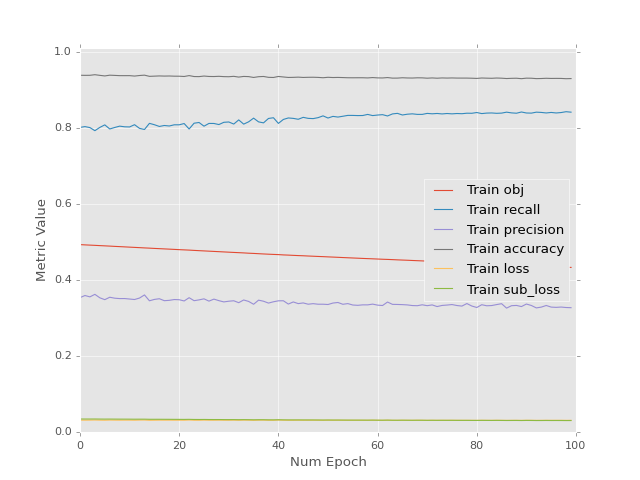

<IPython.core.display.Javascript object>


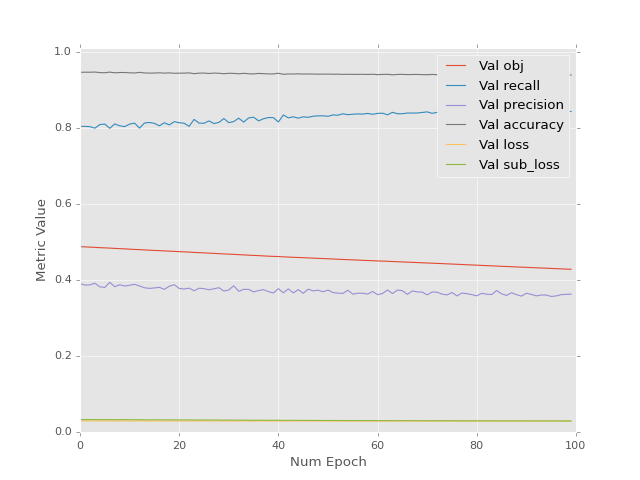

<IPython.core.display.Javascript object>


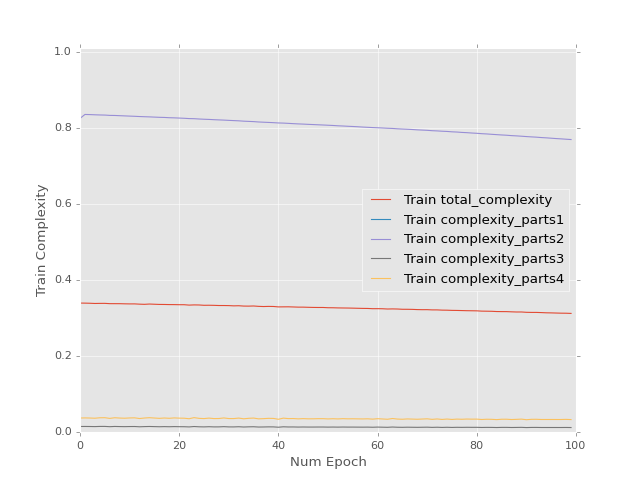

<IPython.core.display.Javascript object>


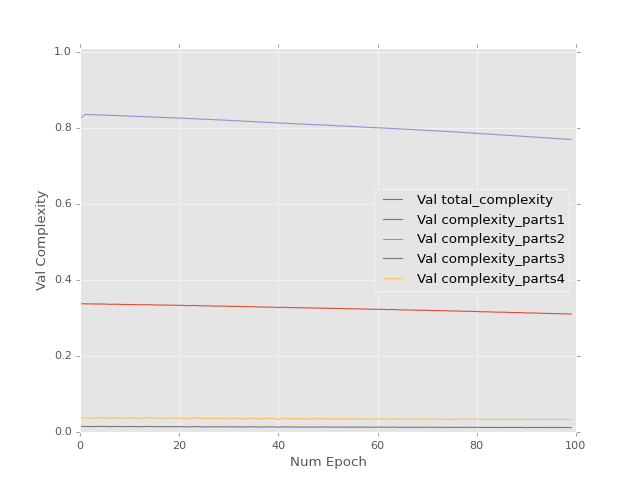

Epoch 1 of 100 took 14.828s
Epoch 2 of 100 took 14.660s
Epoch 3 of 100 took 14.024s
Epoch 4 of 100 took 13.907s
Epoch 5 of 100 took 14.105s
Epoch 6 of 100 took 14.199s
Epoch 7 of 100 took 14.271s
Epoch 8 of 100 took 14.182s
Epoch 9 of 100 took 14.182s
Epoch 10 of 100 took 15.947s
Epoch 11 of 100 took 24.752s
Epoch 12 of 100 took 24.164s
Epoch 13 of 100 took 24.186s
Epoch 14 of 100 took 24.775s
Epoch 15 of 100 took 20.077s
Epoch 16 of 100 took 14.444s
Epoch 17 of 100 took 22.465s
Epoch 18 of 100 took 23.905s
Epoch 19 of 100 took 24.487s
Epoch 20 of 100 took 24.369s
Epoch 21 of 100 took 24.131s
Epoch 22 of 100 took 24.255s
Epoch 23 of 100 took 24.195s
Epoch 24 of 100 took 24.140s
Epoch 25 of 100 took 24.548s
Epoch 26 of 100 took 23.442s
Epoch 27 of 100 took 24.328s
Epoch 28 of 100 took 24.582s
Epoch 29 of 100 took 24.831s
Epoch 30 of 100 took 24.911s
Epoch 31 of 100 took 24.079s
Epoch 32 of 100 took 23.854s
Epoch 33 of 100 took 23.428s
Epoch 34 of 100 took 23.998s
Epoch 35 of 100 took 24

In [26]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)

In [27]:
dataset1 = np.load('../data/not_bright/imgs_0000.npy')
targets1 = np.load('../data/not_bright/masks_0000.npy')

track_targets1 = targets.copy()
track_targets1[track_targets1 <=0] = 0

In [29]:
dataset0 = dataset
track_targets0 = track_targets
targets0 = targets

dataset = np.stack((dataset0, dataset1))
targets = np.stack((targets0, targets1))
track_targets = np.stack((track_targets0, track_targets1))

In [30]:
X_y = train_test_split(dataset.reshape(-1, 1, 512, 512).astype(np.float32),
                       track_targets.reshape(-1, 1, 512, 512).astype(np.float32))

<IPython.core.display.Javascript object>


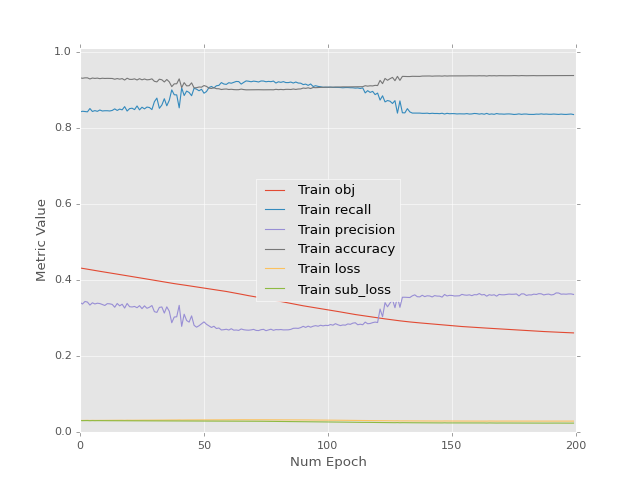

<IPython.core.display.Javascript object>


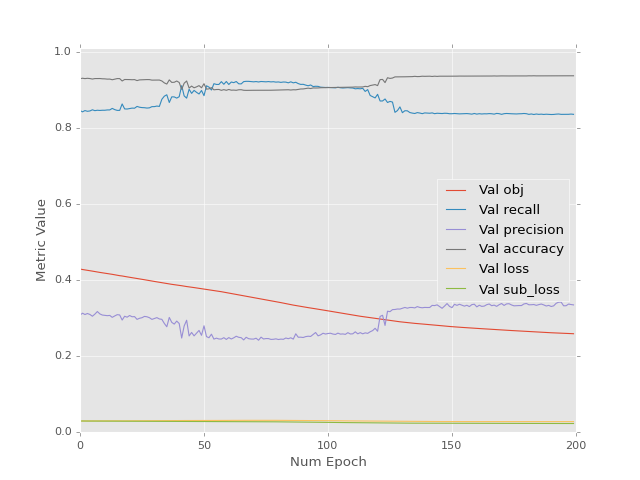

<IPython.core.display.Javascript object>


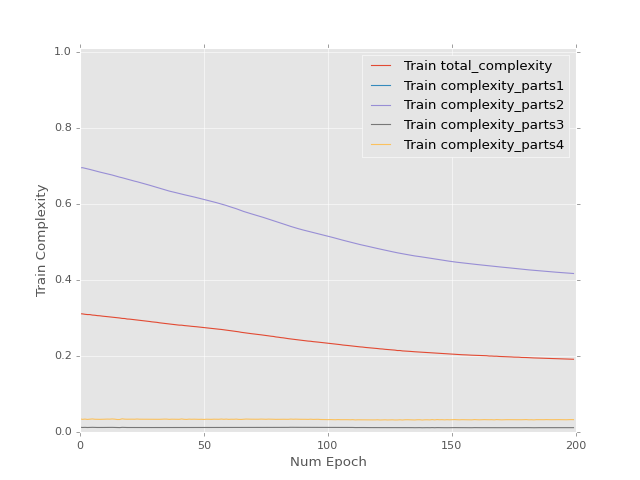

<IPython.core.display.Javascript object>


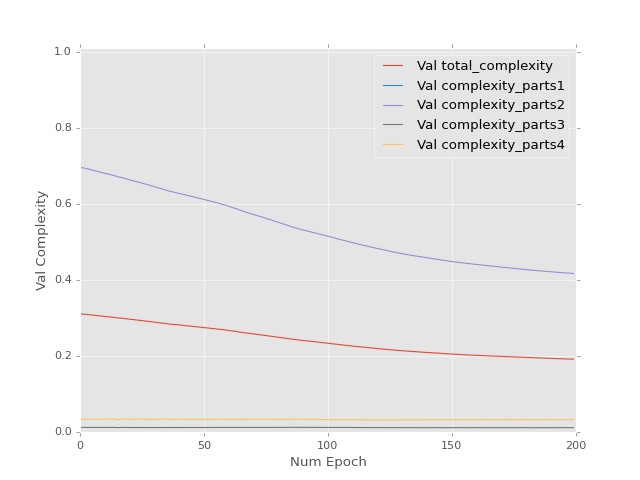

Epoch 1 of 200 took 49.028s
Epoch 2 of 200 took 48.703s
Epoch 3 of 200 took 48.138s
Epoch 4 of 200 took 47.306s
Epoch 5 of 200 took 47.262s
Epoch 6 of 200 took 47.308s
Epoch 7 of 200 took 47.495s
Epoch 8 of 200 took 47.227s
Epoch 9 of 200 took 46.671s
Epoch 10 of 200 took 46.372s
Epoch 11 of 200 took 47.129s
Epoch 12 of 200 took 46.221s
Epoch 13 of 200 took 46.700s
Epoch 14 of 200 took 47.626s
Epoch 15 of 200 took 47.427s
Epoch 16 of 200 took 47.280s
Epoch 17 of 200 took 47.512s
Epoch 18 of 200 took 47.173s
Epoch 19 of 200 took 46.793s
Epoch 20 of 200 took 47.537s
Epoch 21 of 200 took 46.961s
Epoch 22 of 200 took 46.590s
Epoch 23 of 200 took 46.044s
Epoch 24 of 200 took 46.155s
Epoch 25 of 200 took 47.554s
Epoch 26 of 200 took 47.228s
Epoch 27 of 200 took 47.346s
Epoch 28 of 200 took 46.316s
Epoch 29 of 200 took 46.413s
Epoch 30 of 200 took 46.406s
Epoch 31 of 200 took 46.335s
Epoch 32 of 200 took 46.567s
Epoch 33 of 200 took 47.247s
Epoch 34 of 200 took 46.214s
Epoch 35 of 200 took 46

In [31]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=200,
      batch_size=50)

In [32]:
network.save('../weights', '3cascades_difficult')

In [91]:
network.load('../weights', '3cascades_difficult')

# Check results

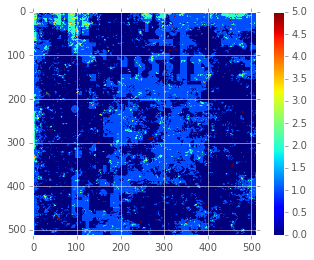

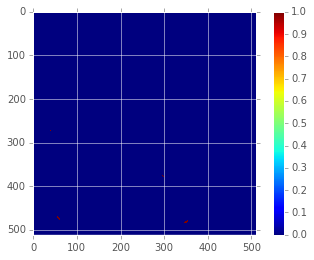

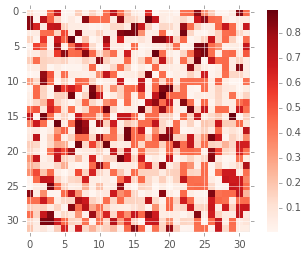

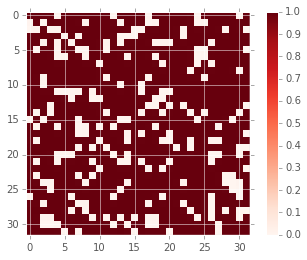

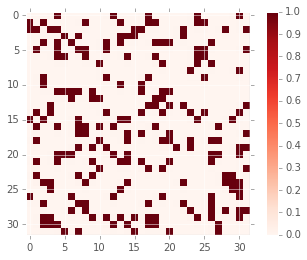

In [41]:
%matplotlib inline
i = np.random.choice(X_y[-1].shape[0])

plt.imshow(X_y[1][i][0])
plt.colorbar()
plt.show()

plt.imshow(X_y[-1][i][0], interpolation='none')
plt.colorbar()
plt.show()

prediction = network.predict(X_y[1][i-1:i].astype(np.float32))

plt.imshow(prediction[0, 0], interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(prediction[0, 0] < 0.5, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(prediction[0, 0] >= 0.5, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

# Precision Vs Recall

In [45]:
import theano
get_target = theano.function([network.targets], lasagne.layers.get_output(network.target_pool_layers[-1]))

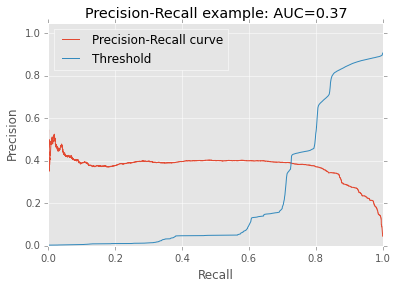

In [56]:
from sklearn.metrics import precision_recall_curve, average_precision_score

x_val = X_y[1][:100]
y_val = X_y[-1][:100]

prediction = network.predict(x_val)
target = get_target(y_val)

precision, recall, thr = precision_recall_curve(target.ravel(), prediction.ravel())
average_precision = average_precision_score(target.ravel(), prediction.ravel())

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.plot(np.arange(thr.shape[0]) / (thr.shape[0] + 1e-6), thr, label='Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc='best')
plt.show()

In [85]:
precision[10000]

0.10983144181048955

In [86]:
thr[10000]

0.011953057

In [87]:
recall[10000]

0.99543517954960437

# Final train

<IPython.core.display.Javascript object>


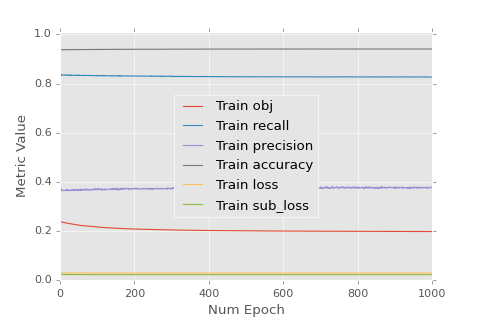

<IPython.core.display.Javascript object>


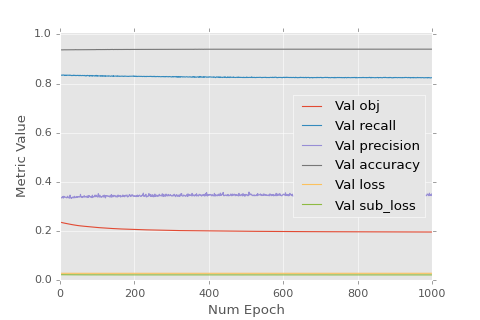

<IPython.core.display.Javascript object>


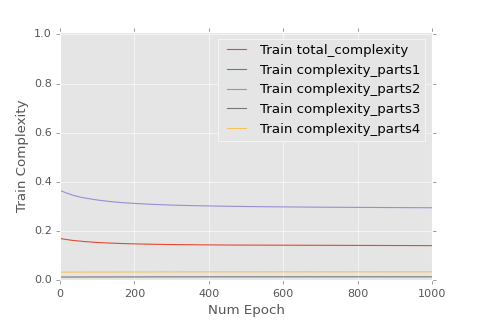

<IPython.core.display.Javascript object>


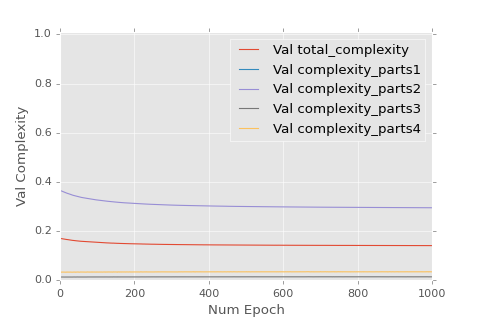

Epoch 1 of 1000 took 28.979s
Epoch 2 of 1000 took 28.756s
Epoch 3 of 1000 took 28.823s
Epoch 4 of 1000 took 29.018s
Epoch 5 of 1000 took 28.900s
Epoch 6 of 1000 took 28.874s
Epoch 7 of 1000 took 28.948s
Epoch 8 of 1000 took 29.153s
Epoch 9 of 1000 took 29.093s
Epoch 10 of 1000 took 28.944s
Epoch 11 of 1000 took 28.851s
Epoch 12 of 1000 took 29.006s
Epoch 13 of 1000 took 29.046s
Epoch 14 of 1000 took 28.885s
Epoch 15 of 1000 took 28.948s
Epoch 16 of 1000 took 28.920s
Epoch 17 of 1000 took 28.923s
Epoch 18 of 1000 took 28.927s
Epoch 19 of 1000 took 28.930s
Epoch 20 of 1000 took 28.947s
Epoch 21 of 1000 took 29.001s
Epoch 22 of 1000 took 29.142s
Epoch 23 of 1000 took 28.844s
Epoch 24 of 1000 took 28.787s
Epoch 25 of 1000 took 28.933s
Epoch 26 of 1000 took 28.875s
Epoch 27 of 1000 took 28.978s
Epoch 28 of 1000 took 29.100s
Epoch 29 of 1000 took 29.016s
Epoch 30 of 1000 took 29.068s
Epoch 31 of 1000 took 29.019s
Epoch 32 of 1000 took 29.116s
Epoch 33 of 1000 took 28.973s
Epoch 34 of 1000 to

In [92]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=1000,
      batch_size=50)

In [93]:
network.save('../weights/', '3cascades_stable_recall')

In [94]:
x_val = X_y[1][:1000]
y_val = X_y[-1][:1000]

network.evaluate(x_val, y_val)

{'accuracy': array(0.94008984375),
 'complexity_parts': array([ 1.        ,  0.26634848,  0.0117286 ,  0.03023199]),
 'loss': array(0.02729051001369953, dtype=float32),
 'obj': array(0.19099866145282557),
 'precision': array(0.34179720282554626),
 'recall': array(0.8237659931182861, dtype=float32),
 'sub_loss': array(0.020793501287698746, dtype=float32),
 'total_complexity': array(0.1356130713875549)}